# Emotional Classification Pipeline

In [2]:
!pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

## Install Packages

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import load_dataset, concatenate_datasets, Dataset
from peft import LoraConfig, get_peft_model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import plotly.express as px
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, hamming_loss
from sklearn.model_selection import train_test_split
import torch
import random


In [4]:
def set_all_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # set_seed(seed)  # HuggingFace transformers seed


## Define Pipeline Parameters

In [5]:
model_name = "Davlan/afro-xlmr-small"  # Base model name
run_baseline = True # Set to True to run the baseline model (skip data augmentation)
languages = ["afr", "hau", "swa"] # List of languages to include, can be run on all languages/specific ones
# languages = ["swa"] # List of languages to include, can be run on all languages/specific ones
seed = 42 # Set a seed for reproducibility

emotion_labels = {
    "joy": 0,
    "anger": 1,
    "fear": 2,
    "sadness": 3,
    "disgust": 4,
    "surprise": 5,
    "neutral": 6,
}

set_all_seeds(seed)

## Load Datasets

In [6]:
def load_datasets(languages):
    # Load the datasets for the specified languages
    # datasets are in the form:
    # {
    #     "lang1": dataset1,
    #     "lang2": dataset2,
    #     ...
    # }

    datasets = {}
    for lang in languages:
        print(f"Loading dataset for {lang}...")
        hf_dataset = load_dataset("brighter-dataset/BRIGHTER-emotion-categories", lang)

        combined_hf_dataset = concatenate_datasets([
            hf_dataset["train"],
            hf_dataset["test"],
            hf_dataset["dev"]
        ])
        datasets[lang] = combined_hf_dataset
        print(f"Loaded {len(combined_hf_dataset)} samples for {lang}.")


    return datasets


datasets = load_datasets(languages)

Loading dataset for afr...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/27.0k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/91.2k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/12.4k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/150k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1222 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/196 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2130 [00:00<?, ? examples/s]

Loaded 3548 samples for afr.
Loading dataset for hau...


train-00000-of-00001.parquet:   0%|          | 0.00/150k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/31.0k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/146k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2145 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/712 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2160 [00:00<?, ? examples/s]

Loaded 5017 samples for hau.
Loading dataset for swa...


train-00000-of-00001.parquet:   0%|          | 0.00/240k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/56.1k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/233k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3307 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/1102 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3312 [00:00<?, ? examples/s]

Loaded 7721 samples for swa.


## Preprocess Dataset
- Map empty emotions to neutral
- Split in to train, validation and test sets using stratified sampling by emotion label
- Add multi-hot encoded label column

In [7]:
def preprocess_datasets(datasets, emotion_to_id_dict):
    # datasets are in form
    # {
    #     "lang1": {
    #         "train": <train_dataset>,
    #         "test": <test_dataset>,
    #         "validation": <validation_dataset>
    #     },
    #     "lang2": {
    #         "train": <train_dataset>,
    #         "test": <test_dataset>,
    #         "validation": <validation_dataset>
    #     },
    #     ...
    # }

    preprocessed_datasets = {}
    for lang, dataset in datasets.items():
        print(f"Preprocessing dataset for {lang}...")

        # Replace empty labels with "neutral"
        dataset = dataset.map(
            lambda example: {
                **example,
                "emotions": example["emotions"] if len(example["emotions"]) > 0 else ["neutral"]
            }
        )

        # Convert the list of emotions to a string representation for stratification
        def categorise_emotions(emotions_list):
            if not emotions_list:
                return "none"
            elif len(emotions_list) == 1:
                return emotions_list[0]
            else:
                return "multiple"

        # Add a new column for stratification
        dataset = dataset.map(
            lambda example: {"emotion_key": categorise_emotions(example["emotions"])}
        )

        # Now split using train_test_split from scikit-learn
        train_size = 0.8
        test_size = 0.1
        dev_size = 0.1

        # Convert to pandas for easier handling with sklearn
        df = dataset.to_pandas()

        print(f"Stratifying by emotion...")
        # First split to get train and the rest
        train_df, temp_df = train_test_split(
            df,
            train_size=train_size,
            stratify=df["emotion_key"],
            random_state=seed
        )

        # Then split the rest into test and dev
        test_df, dev_df = train_test_split(
            temp_df,
            train_size=test_size/(test_size + dev_size),
            stratify=temp_df["emotion_key"],
            random_state=seed
        )

        train_dataset = Dataset.from_pandas(train_df)
        test_dataset = Dataset.from_pandas(test_df)
        dev_dataset = Dataset.from_pandas(dev_df)


        num_labels = len(emotion_to_id_dict)

        # Create a new column 'labels' containing multi-hot encoded labels
        def map_emotions_to_labels(example):
            # Initialise a zero array for all emotions
            labels = [0.0] * num_labels  # Use floats instead of integers

            # Handle both string format and list format
            emotions_list = example['emotions']

            # Set 1 for each emotion present in the example
            for emotion in emotions_list:
                labels[emotion_to_id_dict[emotion]] = 1.0

            example['labels'] = labels
            return example

        # Apply the mapping function to the train, test, and dev datasets
        train_dataset = train_dataset.map(map_emotions_to_labels)
        test_dataset = test_dataset.map(map_emotions_to_labels)
        dev_dataset = dev_dataset.map(map_emotions_to_labels)


        print(f"Dataset for {lang} split with {len(train_dataset)} train, {len(test_dataset)} test, and {len(dev_dataset)} validation samples.")

        # Store the datasets in the dictionary
        preprocessed_datasets[lang] = {
            "train": train_dataset,
            "test": test_dataset,
            "validation": dev_dataset
        }
    return preprocessed_datasets


preprocessed_datasets = preprocess_datasets(datasets.copy(), emotion_labels)

Preprocessing dataset for afr...


Map:   0%|          | 0/3548 [00:00<?, ? examples/s]

Map:   0%|          | 0/3548 [00:00<?, ? examples/s]

Stratifying by emotion...


Map:   0%|          | 0/2838 [00:00<?, ? examples/s]

Map:   0%|          | 0/355 [00:00<?, ? examples/s]

Map:   0%|          | 0/355 [00:00<?, ? examples/s]

Dataset for afr split with 2838 train, 355 test, and 355 validation samples.
Preprocessing dataset for hau...


Map:   0%|          | 0/5017 [00:00<?, ? examples/s]

Map:   0%|          | 0/5017 [00:00<?, ? examples/s]

Stratifying by emotion...


Map:   0%|          | 0/4013 [00:00<?, ? examples/s]

Map:   0%|          | 0/502 [00:00<?, ? examples/s]

Map:   0%|          | 0/502 [00:00<?, ? examples/s]

Dataset for hau split with 4013 train, 502 test, and 502 validation samples.
Preprocessing dataset for swa...


Map:   0%|          | 0/7721 [00:00<?, ? examples/s]

Map:   0%|          | 0/7721 [00:00<?, ? examples/s]

Stratifying by emotion...


Map:   0%|          | 0/6176 [00:00<?, ? examples/s]

Map:   0%|          | 0/772 [00:00<?, ? examples/s]

Map:   0%|          | 0/773 [00:00<?, ? examples/s]

Dataset for swa split with 6176 train, 772 test, and 773 validation samples.


# Apply data augmentation techique
> Skips if running baseline model

In [8]:
def augment_datasets(datasets):
    if run_baseline:
        print("Running baseline model, skipping data augmentation.")
        return datasets

    # This is where you would implement your augmentation logic to augment the train datasets
    for lang, dataset in datasets:
        print(f"Augmenting dataset for {lang}...")
        training_set = dataset["training"].copy()
        # Implement your augmentation logic here
    raise NotImplementedError("Dataset augmentation logic is not implemented yet.")



augmented_datasets = augment_datasets(preprocessed_datasets.copy())


Running baseline model, skipping data augmentation.


# Tokenize the datasets

In [9]:
xmlr_tokenizer = AutoTokenizer.from_pretrained(model_name)

def preprocess(batch):
    return xmlr_tokenizer(batch['text'], truncation=True, padding='max_length', max_length=128)

tokenized_datasets = {}
for lang, dataset in augmented_datasets.items():
    print(f"Tokenizing dataset for {lang}...")
    tokenized_datasets[lang] = {}
    tokenized_datasets[lang]['train'] = dataset['train'].map(preprocess, batched=True)
    tokenized_datasets[lang]['test'] = dataset['test'].map(preprocess, batched=True)
    tokenized_datasets[lang]['validation'] = dataset['validation'].map(preprocess, batched=True)
    # Set the format for PyTorch
    tokenized_datasets[lang]['train'].set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
    tokenized_datasets[lang]['test'].set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
    tokenized_datasets[lang]['validation'].set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
    print(f"Tokenized dataset for {lang}")



tokenizer_config.json:   0%|          | 0.00/536 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.71M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

Tokenizing dataset for afr...


Map:   0%|          | 0/2838 [00:00<?, ? examples/s]

Map:   0%|          | 0/355 [00:00<?, ? examples/s]

Map:   0%|          | 0/355 [00:00<?, ? examples/s]

Tokenized dataset for afr
Tokenizing dataset for hau...


Map:   0%|          | 0/4013 [00:00<?, ? examples/s]

Map:   0%|          | 0/502 [00:00<?, ? examples/s]

Map:   0%|          | 0/502 [00:00<?, ? examples/s]

Tokenized dataset for hau
Tokenizing dataset for swa...


Map:   0%|          | 0/6176 [00:00<?, ? examples/s]

Map:   0%|          | 0/772 [00:00<?, ? examples/s]

Map:   0%|          | 0/773 [00:00<?, ? examples/s]

Tokenized dataset for swa


# Train Model

In [10]:
# Mignon added
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    hamming_loss,
    multilabel_confusion_matrix
)
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    sigmoid = lambda x: 1 / (1 + np.exp(-x))
    probs = sigmoid(logits)
    preds = (probs >= 0.3).astype(int)

    # Get multilabel confusion matrix: shape (num_labels, 2, 2)
    mcm = multilabel_confusion_matrix(labels, preds)

    # Convert to dict for logging/inspection
    confusion_dict = {
        f"label_{i}": {
            "tn": int(cm[0][0]),
            "fp": int(cm[0][1]),
            "fn": int(cm[1][0]),
            "tp": int(cm[1][1]),
        }
        for i, cm in enumerate(mcm)
    }

    return {
        "subset_accuracy": accuracy_score(labels, preds),
        "hamming_loss": hamming_loss(labels, preds),
        "macro_f1": f1_score(labels, preds, average="macro", zero_division=0),
        "micro_f1": f1_score(labels, preds, average="micro", zero_division=0),
        "macro_precision": precision_score(labels, preds, average="macro", zero_division=0),
        "micro_precision": precision_score(labels, preds, average="micro", zero_division=0),
        "macro_recall": recall_score(labels, preds, average="macro", zero_division=0),
        "micro_recall": recall_score(labels, preds, average="micro", zero_division=0),
        "confusion_matrix": confusion_dict
    }

def train_finetune(train_data, val_data, num_labels, lang):
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_labels,
        problem_type="multi_label_classification"  # Set problem type for multi-label
    )

    args = TrainingArguments(
        output_dir=f"{model_name}-{lang}-ft",
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=5,
        save_strategy="no",
        report_to="none",
        logging_dir=None,
        seed=seed,  # Add seed to training arguments
        data_seed=seed,  # Add data seed for data loading
        dataloader_num_workers=0,  # Ensure deterministic data loading
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_data,
        eval_dataset=val_data,
        compute_metrics=compute_metrics
    )
    trainer.train()
    return trainer


trainers = {}
for lang, datasets in augmented_datasets.items():
    print(f"\nTraining on {lang} dataset...")

    num_labels = len(emotion_labels)
    set_all_seeds(seed)
    trainers[lang] = train_finetune(tokenized_datasets[lang]["train"],tokenized_datasets[lang]["validation"], num_labels, lang)
    results = trainers[lang].evaluate(tokenized_datasets[lang]["validation"], metric_key_prefix="eval")
    print("Training Fine-tuning Accuracy:", results['eval_subset_accuracy'])
    print("Training Hamming Loss:", results['eval_hamming_loss'])
    print("Macro F1 Score", results['eval_macro_f1'])
    print("Micro F1 Score", results['eval_micro_f1'])
    print("Micro Precision", results['eval_micro_precision'])
    print("Micro Recall", results['eval_micro_recall'])
    print("Macro Precision", results['eval_macro_precision'])
    print("Macro Recall", results['eval_macro_recall'])
    print("Confusion Matrix", results['eval_confusion_matrix'])


Training on afr dataset...


config.json:   0%|          | 0.00/757 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/561M [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.237000


Training Fine-tuning Accuracy: 0.6985915492957746
Training Hamming Loss: 0.07605633802816901
Macro F1 Score 0.6104101330411597
Micro F1 Score 0.7725631768953068
Micro Precision 0.7535211267605634
Micro Recall 0.7925925925925926
Macro Precision 0.6050573539108316
Macro Recall 0.6244718865987523
Confusion Matrix {'label_0': {'tn': 192, 'fp': 28, 'fn': 22, 'tp': 113}, 'label_1': {'tn': 325, 'fp': 6, 'fn': 13, 'tp': 11}, 'label_2': {'tn': 294, 'fp': 21, 'fn': 12, 'tp': 28}, 'label_3': {'tn': 280, 'fp': 19, 'fn': 7, 'tp': 49}, 'label_4': {'tn': 334, 'fp': 5, 'fn': 5, 'tp': 11}, 'label_5': {'tn': 355, 'fp': 0, 'fn': 0, 'tp': 0}, 'label_6': {'tn': 195, 'fp': 26, 'fn': 25, 'tp': 109}}

Training on hau dataset...


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.336300
1000,0.181200


Training Fine-tuning Accuracy: 0.5717131474103586
Training Hamming Loss: 0.09817871371656232
Macro F1 Score 0.7306121808890389
Micro F1 Score 0.7364400305576776
Micro Precision 0.7016011644832606
Micro Recall 0.77491961414791
Macro Precision 0.7113242201130665
Macro Recall 0.7595255349294991
Confusion Matrix {'label_0': {'tn': 404, 'fp': 23, 'fn': 15, 'tp': 60}, 'label_1': {'tn': 382, 'fp': 27, 'fn': 20, 'tp': 73}, 'label_2': {'tn': 383, 'fp': 30, 'fn': 9, 'tp': 80}, 'label_3': {'tn': 284, 'fp': 71, 'fn': 25, 'tp': 122}, 'label_4': {'tn': 418, 'fp': 11, 'fn': 12, 'tp': 61}, 'label_5': {'tn': 398, 'fp': 24, 'fn': 26, 'tp': 54}, 'label_6': {'tn': 418, 'fp': 19, 'fn': 33, 'tp': 32}}

Training on swa dataset...


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.373500
1000,0.367400
1500,0.367800


Training Fine-tuning Accuracy: 0.445019404915912
Training Hamming Loss: 0.16466457216780633
Macro F1 Score 0.08799079166133776
Micro F1 Score 0.4357188093730209
Micro Precision 0.445019404915912
Micro Recall 0.4267990074441687
Macro Precision 0.06357420070227314
Macro Recall 0.14285714285714285
Confusion Matrix {'label_0': {'tn': 670, 'fp': 0, 'fn': 103, 'tp': 0}, 'label_1': {'tn': 702, 'fp': 0, 'fn': 71, 'tp': 0}, 'label_2': {'tn': 751, 'fp': 0, 'fn': 22, 'tp': 0}, 'label_3': {'tn': 691, 'fp': 0, 'fn': 82, 'tp': 0}, 'label_4': {'tn': 719, 'fp': 0, 'fn': 54, 'tp': 0}, 'label_5': {'tn': 643, 'fp': 0, 'fn': 130, 'tp': 0}, 'label_6': {'tn': 0, 'fp': 429, 'fn': 0, 'tp': 344}}


# Test Model

In [11]:
def test_model(trainer, test_data):
    # Reuse the already loaded tokenizer
    test_results = trainer.evaluate(
        test_data,
        metric_key_prefix="test"
    )

    print("Test Accuracy:", test_results['test_subset_accuracy'])
    print("Test Hamming Loss:", test_results['test_hamming_loss'])
    print("Test Macro F1 Score:", test_results['test_macro_f1'])
    print("Test Micro F1 Score:", test_results['test_micro_f1'])
    print("Test Micro Precision:", test_results['test_micro_precision'])
    print("Test Micro Recall:", test_results['test_micro_recall'])
    print("Test Macro Precision:", test_results['test_macro_precision'])
    print("Test Macro Recall:", test_results['test_macro_recall'])
    print("Confusion Matrix", test_results['test_confusion_matrix'])

    return test_results

for lang, datasets in augmented_datasets.items():
    print(f"\nTesting {lang} model on test {lang} dataset...")
    test_results = test_model(trainers[lang], tokenized_datasets[lang]["test"])



Testing afr model on test afr dataset...


Test Accuracy: 0.6901408450704225
Test Hamming Loss: 0.08169014084507042
Test Macro F1 Score: 0.6168872361258914
Test Micro F1 Score: 0.7608951707891637
Test Micro Precision: 0.7307692307692307
Test Micro Recall: 0.7936117936117936
Test Macro Precision: 0.5892066124488234
Test Macro Recall: 0.649840654323751
Confusion Matrix {'label_0': {'tn': 190, 'fp': 27, 'fn': 20, 'tp': 118}, 'label_1': {'tn': 328, 'fp': 8, 'fn': 7, 'tp': 12}, 'label_2': {'tn': 289, 'fp': 24, 'fn': 11, 'tp': 31}, 'label_3': {'tn': 270, 'fp': 27, 'fn': 16, 'tp': 42}, 'label_4': {'tn': 336, 'fp': 4, 'fn': 3, 'tp': 12}, 'label_5': {'tn': 355, 'fp': 0, 'fn': 0, 'tp': 0}, 'label_6': {'tn': 191, 'fp': 29, 'fn': 27, 'tp': 108}}

Testing hau model on test hau dataset...


Test Accuracy: 0.6175298804780877
Test Hamming Loss: 0.08651109846328969
Test Macro F1 Score: 0.7624394866064277
Test Micro F1 Score: 0.7689969604863222
Test Micro Precision: 0.7322720694645442
Test Micro Recall: 0.8096
Test Macro Precision: 0.7399195743186838
Test Macro Recall: 0.797341706347775
Confusion Matrix {'label_0': {'tn': 401, 'fp': 23, 'fn': 17, 'tp': 61}, 'label_1': {'tn': 385, 'fp': 23, 'fn': 18, 'tp': 76}, 'label_2': {'tn': 394, 'fp': 34, 'fn': 6, 'tp': 68}, 'label_3': {'tn': 297, 'fp': 54, 'fn': 16, 'tp': 135}, 'label_4': {'tn': 414, 'fp': 9, 'fn': 26, 'tp': 53}, 'label_5': {'tn': 395, 'fp': 22, 'fn': 18, 'tp': 67}, 'label_6': {'tn': 418, 'fp': 20, 'fn': 18, 'tp': 46}}

Testing swa model on test swa dataset...


Test Accuracy: 0.44430051813471505
Test Hamming Loss: 0.16469282013323464
Test Macro F1 Score: 0.08789237668161434
Test Micro F1 Score: 0.4352791878172589
Test Micro Precision: 0.44430051813471505
Test Micro Recall: 0.42661691542288555
Test Macro Precision: 0.06347150259067358
Test Macro Recall: 0.14285714285714285
Confusion Matrix {'label_0': {'tn': 668, 'fp': 0, 'fn': 104, 'tp': 0}, 'label_1': {'tn': 700, 'fp': 0, 'fn': 72, 'tp': 0}, 'label_2': {'tn': 748, 'fp': 0, 'fn': 24, 'tp': 0}, 'label_3': {'tn': 687, 'fp': 0, 'fn': 85, 'tp': 0}, 'label_4': {'tn': 718, 'fp': 0, 'fn': 54, 'tp': 0}, 'label_5': {'tn': 650, 'fp': 0, 'fn': 122, 'tp': 0}, 'label_6': {'tn': 0, 'fp': 429, 'fn': 0, 'tp': 343}}


In [15]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

def plot_multilabel_roc(trainer, dataset, emotion_labels, lang):
    # Get raw predictions and labels
    outputs = trainer.predict(dataset)
    logits = outputs.predictions
    labels = outputs.label_ids

    sigmoid = lambda x: 1 / (1 + np.exp(-x))
    probs = sigmoid(logits)  # Shape: [num_samples, num_labels]

    num_labels = len(emotion_labels)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_labels):
        fpr[i], tpr[i], _ = roc_curve(labels[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    label_names = [None] * len(emotion_labels)
    for k, v in emotion_labels.items():
        label_names[v] = k

    # Plot
    plt.figure(figsize=(10, 8))
    for i in range(num_labels):
        plt.plot(fpr[i], tpr[i], label=f"{label_names[i]} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curves for Language: {lang}")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Plotting ROC curve for afr


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


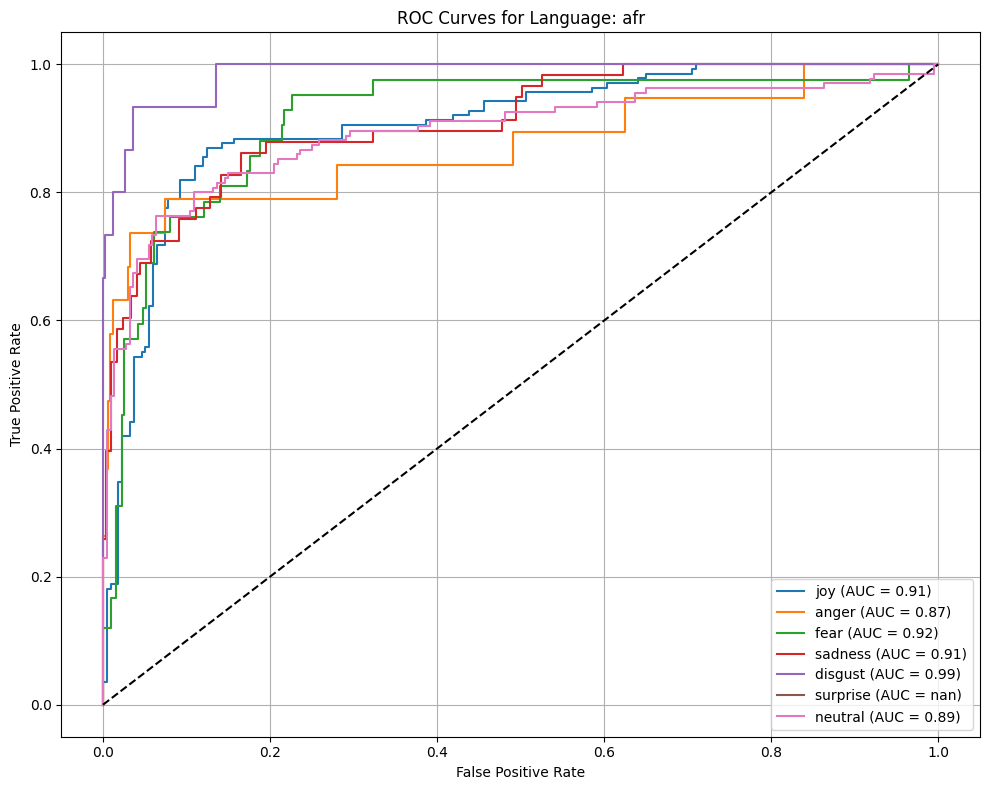

Plotting ROC curve for hau


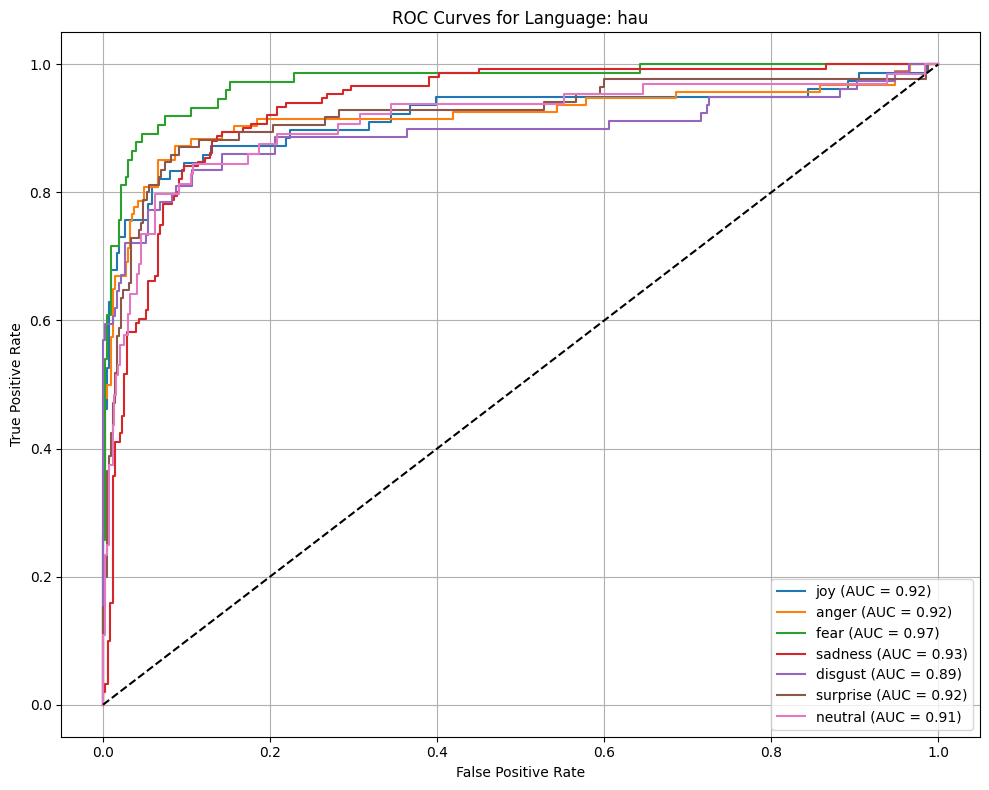

Plotting ROC curve for swa


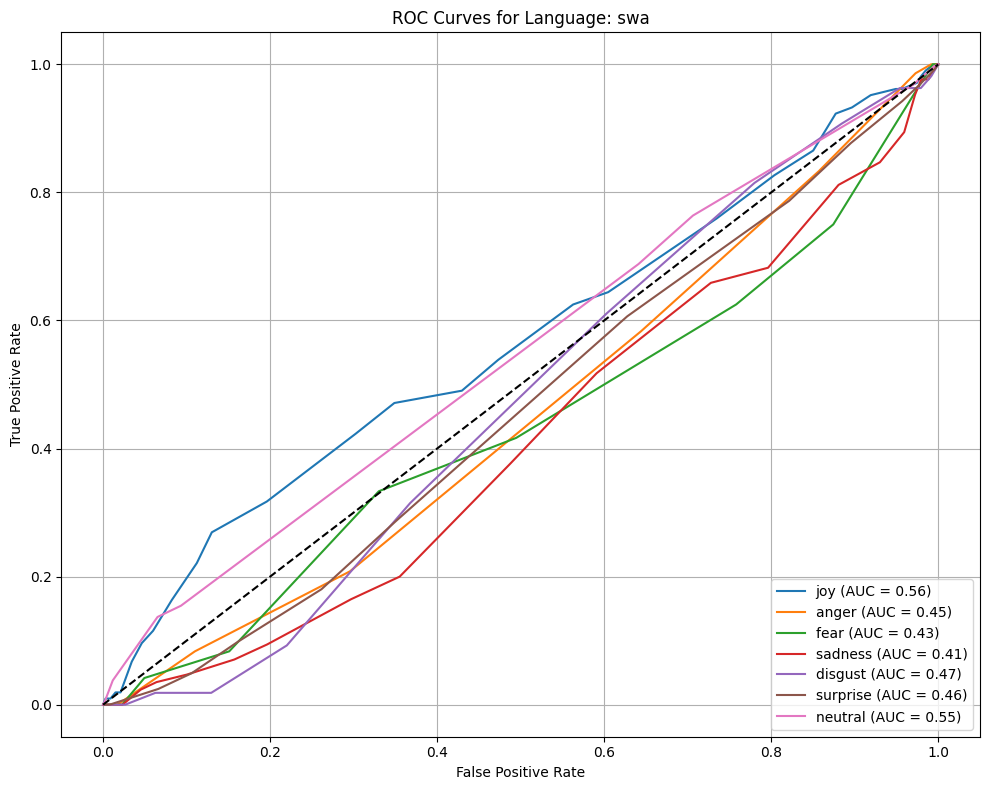

In [16]:
for lang in trainers:
    print(f"Plotting ROC curve for {lang}")
    plot_multilabel_roc(trainers[lang], tokenized_datasets[lang]["test"], emotion_labels, lang)

# Parameter Tuning

In [12]:
# param_grid = {
#     "learning_rate": [2e-5, 3e-5, 5e-5],
#     "batch_size": [8, 16],
#     "epochs": [3, 5],
#     "threshold": [0.3, 0.5, 0.7]
# }


In [13]:
# def train_finetune(model_ckpt, train_data, test_data, num_labels, lr, batch_size, epochs, threshold):
#     model = AutoModelForSequenceClassification.from_pretrained(
#         model_ckpt,
#         num_labels=num_labels,
#         problem_type="multi_label_classification"
#     )


#     args = TrainingArguments(
#         output_dir=f"{model_ckpt}-finetuned",
#         per_device_train_batch_size=batch_size,
#         per_device_eval_batch_size=batch_size,
#         learning_rate=lr,
#         num_train_epochs=epochs,
#         save_strategy="no",
#         report_to="none",
#         logging_dir=None,
#         seed=seed,  # Add seed to training arguments
#         data_seed=seed,  # Add data seed for data loading
#         dataloader_num_workers=0,  # Ensure deterministic data loading
#     )

#     def compute_metrics(eval_pred):
#         logits, labels = eval_pred
#         sigmoid = lambda x: 1 / (1 + np.exp(-x))
#         probs = sigmoid(logits)
#         preds = (probs >= threshold).astype(int)

#         return {
#             "subset_accuracy": accuracy_score(labels, preds),
#             "hamming_loss": hamming_loss(labels, preds),
#             "macro_f1": f1_score(labels, preds, average="macro", zero_division=0),
#             "micro_f1": f1_score(labels, preds, average="micro", zero_division=0),
#         }

#     trainer = Trainer(
#         model=model,
#         args=args,
#         train_dataset=train_data,
#         eval_dataset=test_data,
#         compute_metrics=compute_metrics
#     )

#     trainer.train()
#     results = trainer.evaluate()
#     return results


In [14]:
# import itertools
# import numpy as np
# from collections import defaultdict

# # Dictionary to store results for each language
# language_results = {}
# # Dictionary to track average performance across languages for each parameter combination
# param_avg_scores = defaultdict(float)
# # To count how many languages we test on (for averaging)
# num_languages = len(languages)

# # Create a compact parameter key format for readability
# def param_key(lr, batch_size, epochs, threshold):
#     return f"lr={lr}_bs={batch_size}_ep={epochs}_th={threshold}"

# print(f"Parameter tuning across {num_languages} languages: {', '.join(languages)}")

# num_labels = len(emotion_labels)
# # Generate all parameter combinations once
# param_combinations = list(itertools.product(
#     param_grid["learning_rate"],
#     param_grid["batch_size"],
#     param_grid["epochs"],
#     param_grid["threshold"]
# ))

# # First, train and evaluate on each language separately
# for lang in languages:
#     print(f"\n{'='*50}")
#     print(f"TUNING ON LANGUAGE: {lang}")
#     print(f"{'='*50}")

#     language_results[lang] = []
#     best_lang_score = 0
#     best_lang_params = {}

#     for lr, batch_size, epochs, threshold in param_combinations:
#         print(f"\nTesting on {lang}: lr={lr}, batch_size={batch_size}, epochs={epochs}, threshold={threshold}")

#         set_all_seeds(seed)
#         # Train and evaluate on this language with these parameters
#         results = train_finetune(
#             "Davlan/afro-xlmr-small",
#             tokenized_datasets[lang]["train"],
#             tokenized_datasets[lang]["validation"],
#             num_labels, lr, batch_size, epochs, threshold
#         )

#         # Extract the score (using micro_f1 as our metric)
#         score = results["eval_micro_f1"]
#         print(f"{lang} Micro-F1 Score: {score:.4f}")

#         # Store results for this language
#         language_results[lang].append((score, lr, batch_size, epochs, threshold))

#         # Update best parameters for this language
#         if score > best_lang_score:
#             best_lang_score = score
#             best_lang_params = {
#                 "learning_rate": lr,
#                 "batch_size": batch_size,
#                 "epochs": epochs,
#                 "threshold": threshold
#             }

#         # Add to our running average across languages
#         param_key_str = param_key(lr, batch_size, epochs, threshold)
#         param_avg_scores[param_key_str] += score / num_languages

#     # Print the best parameters for this language
#     print(f"\n✅ Best parameters for {lang}:")
#     print(best_lang_params)
#     print(f"Best {lang} Micro-F1 Score: {best_lang_score:.4f}")

# # Find the parameter combination with the best average performance across languages
# best_avg_score = 0
# best_avg_params = None

# for params, avg_score in param_avg_scores.items():
#     if avg_score > best_avg_score:
#         best_avg_score = avg_score
#         best_avg_params = params

# # Parse the parameter key back into a dictionary
# lr, batch_size, epochs, threshold = best_avg_params.split("_")
# best_params = {
#     "learning_rate": float(lr.split('=')[1]),
#     "batch_size": int(batch_size.split('=')[1]),
#     "epochs": int(epochs.split('=')[1]),
#     "threshold": float(threshold.split('=')[1])
# }

# print("\n" + "="*70)
# print("FINAL RESULTS ACROSS ALL LANGUAGES")
# print("="*70)
# print("\n✅ Best overall parameters (averaged across all languages):")
# print(best_params)
# print(f"Average Micro-F1 Score: {best_avg_score:.4f}")

# # Create a performance matrix to visualize results
# print("\nPerformance across languages:")
# print(f"{'Parameters':<40} | {'Average':<10} | " + " | ".join([f"{lang:<10}" for lang in languages]))
# print("-" * (50 + 12 * num_languages))

# # Sort parameter combinations by average score for better readability
# sorted_params = sorted(param_avg_scores.items(), key=lambda x: x[1], reverse=True)

# # Print top 5 parameter combinations
# for i, (params, avg_score) in enumerate(sorted_params[:5]):
#     # Get individual language scores for this parameter combination
#     lang_scores = []
#     for lang in languages:
#         # Find the score for this parameter combination in this language
#         for result in language_results[lang]:
#             score, lr, bs, ep, th = result
#             if param_key(lr, bs, ep, th) == params:
#                 lang_scores.append(score)
#                 break

#     # Print the row
#     print(f"{params:<40} | {avg_score:.4f}      | " + " | ".join([f"{score:.4f}      " for score in lang_scores]))
